In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from transformers import pipeline

In [2]:
# load toxicity annotation model
toxpipe = pipeline("text-classification", model="cooperleong00/deberta-v3-large_toxicity-scorer")

In [3]:
# read in original data
dfa = pd.read_csv('../data/toxicity_annotations.tsv',sep='\t')
dfc = pd.read_csv('../data/toxicity_annotated_comments.tsv',sep='\t')

# read in dialect subsets
aave = pd.read_json("../data/aave.jsonl", lines=True)
nigerianD = pd.read_json("../data/nigerianD.jsonl", lines=True)
indianD = pd.read_json("../data/indianD.jsonl", lines=True)
singlish = pd.read_json("../data/singlish.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
dfa_sample = dfa.iloc[:1000]

In [4]:
dfa_sample.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [5]:
dfc.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [6]:
aave.head()

,text,rules
0,This:NEWLINE_TOKEN:One might can make an analo...,"[existential_there, mass_noun_plurals, complet..."
1,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,"[shadow_pronouns, existential_there, regulariz..."
2,Elected or Electoral? JHK,[]
3,`This such a fun entry. DevotchkaNEWLINE_TOK...,"[regularized_plurals, their_they, future_sub_g..."
4,Please do relate that ozone hole to increase i...,"[zero_plural, double_modals, demonstrative_for..."


### DeBERTa accuracy check

In [7]:
y_gold = dfa_sample["toxicity_score"]

print(Counter(list(y_gold[:500])))

Counter({0.0: 250, 1.0: 213, -1.0: 19, 2.0: 17, -2.0: 1})


In [8]:
# for sent in dfc["comment"][:5]:
#     results = toxpipe(sent)
#     print(results)

In [9]:
y_pred = []
for sent in tqdm(dfc["comment"][:1000]):
    result = toxpipe(sent)[0]

    # score_num: numerical score of toxicity rating: (-1 ~ 1)
    if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
        score_num = -result["score"]
    else:
        score_num = result["score"]

    # score_cat: categorical rating of toxicity: [-2, -1, 0, 1, 2]
    if -1.0 <= score_num < -0.6:
        score_cat = -2
    elif -0.6 <= score_num < -0.2:
        score_cat = -1
    elif -0.2 <= score_num <= 0.2:
        score_cat = 0
    elif 0.2 < score_num <= 0.6:
        score_cat = 1
    elif 0.6 < score_num <= 1.0:
        score_cat = 2
    else:
        score_cat = None  # Handle out-of-range value

    res = [score_cat, score_num]
    y_pred.append(res)

100%|██████████| 1000/1000 [24:11<00:00,  1.45s/it] 


In [10]:
Counter([i[0] for i in y_pred])

Counter({2: 940, 1: 24, -2: 20, -1: 16})

In [11]:
# convert results to a df with labels
pred_1k = pd.DataFrame(y_pred, columns =['label', 'confidence'], dtype = float) 

# save the first 500 predictions with confidence
pred_1k.to_csv("../data/pred_1k.csv", sep=",", index=False)

In [12]:
# also test on converted AAVE texts
y_pred_aave = []
for sent in tqdm(aave["text"]):
    result = toxpipe(sent)[0]

    # score_num: numerical score of toxicity rating: (-1 ~ 1)
    if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
        score_num = -result["score"]
    else:
        score_num = result["score"]

    # score_cat: categorical rating of toxicity: [-2, -1, 0, 1, 2]
    if -1.0 <= score_num < -0.6:
        score_cat = -2
    elif -0.6 <= score_num < -0.2:
        score_cat = -1
    elif -0.2 <= score_num <= 0.2:
        score_cat = 0
    elif 0.2 < score_num <= 0.6:
        score_cat = 1
    elif 0.6 < score_num <= 1.0:
        score_cat = 2
    else:
        score_cat = None  # Handle out-of-range value

    res = [score_cat, score_num]
    y_pred_aave.append(res)

pred_aave_1k = pd.DataFrame(y_pred_aave, columns =['label', 'confidence'], dtype = float) 
pred_aave_1k.to_csv("../data/pred_aave_1k.csv", sep=",", index=False)

100%|██████████| 1000/1000 [24:32<00:00,  1.47s/it] 


### check DeBERTa toxicity ratings of the first 1000  sentences

In [16]:
pred_1k = pd.read_csv("../data/pred_1k.csv")
pred_aave_1k = pd.read_csv("../data/pred_aave_1k.csv")

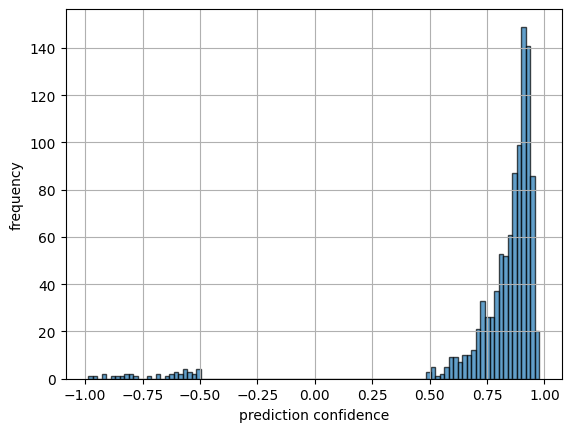

In [14]:
confidence = list(pred_1k["confidence"]) 

plt.hist(confidence, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.grid(True)
plt.show()

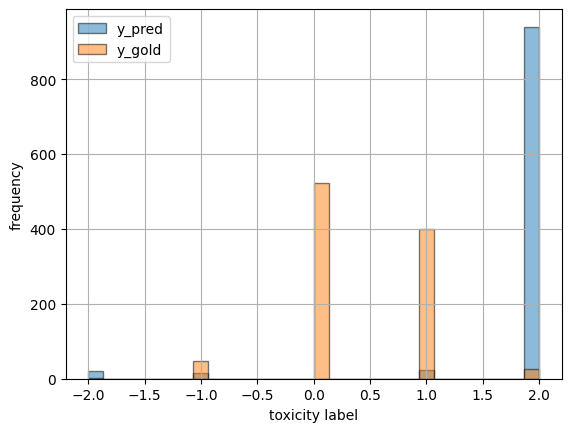

In [23]:
pred_label = list(pred_1k["label"]) 

plt.hist(pred_label, bins=30, edgecolor='black', alpha=0.5, label='y_pred')
plt.hist(y_gold, bins=30, edgecolor='black', alpha=0.5, label='y_gold')

plt.xlabel('toxicity label')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

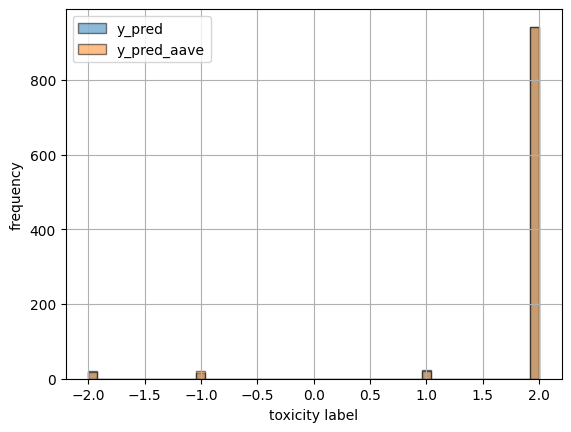

In [22]:
pred_aave_label = list(pred_aave_1k["label"])

plt.hist(pred_label, bins=50, edgecolor="black", alpha=0.5, label="y_pred")
plt.hist(pred_aave_label, bins=50, edgecolor="black", alpha=0.5, label="y_pred_aave")

plt.xlabel("toxicity label")
plt.ylabel("frequency")
plt.legend()
plt.grid(True)
plt.show()

### Problem

The "translated" results are not really distinctive and probably will not be helpful for the toxicity level change evaluation. 

Two possible approaches to make the results useful: 

- use DeBERTa to annotate all 5 dialects. Set original Wiki scores as gold. Compare how the percentile changes
    - keep the (-1 ~ 1) range, where -1 == toxic
    - problem: |score| < 0.50 are quite rare
- train a simple toxicity scorer from scratch. Make sure toxicity labels are consistent
    - problem: How to choose algorithms? How good will the model be?
    - resouce intensive